# **Data Science Final Project** #
- Analyzing patterns and trends at Epic and Ikon ski resorts in the U.S.
- "Prescribing" resorts for skiiers
- Visualizing degees of difference among resorts
- Is there a difference between Epic resorts and Ikon resorts?
  - training a model to attempt to predict whether a resort is and Ikon Pass resort or an Epic Pass resort

## Step 1) Data Cleaning ##

In [96]:
## step 1) data cleaning ##

# import necessary tools:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# import US resort data:
EpicIkon21_22 = pd.read_csv("/workspaces/DS_project/Raw_Data/SkiPassProject.csv")
EpicIkon23_snow = pd.read_csv("/workspaces/DS_project/Raw_Data/annualsnow.csv")
EpicIkon23_season = pd.read_csv("Raw_Data/currentseason.csv")
EpicIkon23_resorts = pd.read_csv("/workspaces/DS_project/Raw_Data/skiresorts.csv")
EpicIkon24 = pd.read_csv("Raw_Data/2024_epic_ikon_resorts_stats.csv")


In [97]:
# 1a) Finding how many resorts are in all three datasets, 
#   and making one BIG dataset with all overlapping resorts:

# rename EpicIkon24 column to match others
EpicIkon24 = EpicIkon24[EpicIkon24["country"] == "United States"] # keep only US resorts
EpicIkon24 = EpicIkon24.rename(columns={"ski_resort_name": "Resort"})

# see if they have the same resorts
EpicIkon21_22["Resort"].isin(EpicIkon23_resorts["Resort"]) # how many resorts in EpicIkon21_22 are also in EpicIkon23_resorts

print(EpicIkon21_22.columns)
print(EpicIkon23_resorts.columns)

# removing unnecessary columns (duplicate information)
EpicIkon23_uniq = EpicIkon23_resorts.drop(columns = ["Location", "Pass", "Total Lifts", "Base Elevation", "Summit height", "Vertical Drop", 
                                                     "Skiable Terrain",
                                                      "Runs in Total", "Projected Opening", "Projected Closing",
                                                      "Projected Days Open",
                                                      "Days Open Last Year", "Average Snowfall", "Beginners Runs", "Intermediate Runs", "Advanced Runs", "Expert Runs"])
EpicIkon23_uniq.head()

# remove unnecesary columsn from EpicIkon24:
keep_cols = ["Resort", "skiable_acres", "base_elevation_ft", "top_elevation_ft", 
             "vertical_ft", "trails", "historical_average_snowfall_inches","historical_average_snowfall_days"]
EpicIkon24_uniq = EpicIkon24[keep_cols]

##  Renaming Resorts to match:
EpicIkon21_22["Resort"] = EpicIkon21_22["Resort"].str.replace(r" Ski Resort$| Ski Area$| Resort$", "", regex=True)
EpicIkon23_uniq["Resort"] = EpicIkon23_uniq["Resort"].str.replace(r" Ski Resort$| Ski Area$| Resort$", "", regex=True)
EpicIkon24_uniq["Resort"] = EpicIkon24_uniq["Resort"].str.replace(r" Ski Resort$| Ski Area$| Resort$", "", regex=True)
# (the above removes words like "Ski resort" or "ski area" to make names more consistent across the three datasets)

# i manually looked at what names were still off, but had matching resorts and changed the names here:
rename_EpicIkon24 = {
    "Jackson Hole Mountain Resort": "Jackson Hole",
    "Eldora Mountain Resort": "Eldora",
    "Heavenly Mountain Resort": "Heavenly",
    "Killington Ski Resort": "Killington",
    "Kirkwood Mountain Resort": "Kirkwood",
    "Okemo Mountain Resort": "Okemo",
    "Park City Mountain": "Park City",
    "Solitude Mountain Resort": "Solitude",
    "Stowe Mountain Resort": "Stowe"}
EpicIkon24_uniq["Resort"] = EpicIkon24_uniq["Resort"].replace(rename_EpicIkon24)

# what resorts are in both 21_22 and 24?
Resorts_21_and_24 = EpicIkon24_uniq["Resort"].isin(EpicIkon21_22["Resort"]).reset_index()
Resorts_21_and_24

# make df with resort names and boolean for if in both datasets
Resorts_21_22_bool = pd.DataFrame({
    "Resort": EpicIkon21_22["Resort"],
    "In_24": EpicIkon21_22["Resort"].isin(EpicIkon24_uniq["Resort"])
})

# after changes, checking which resorts are still NOT in both datasets 
#   (and double checking for spelling or naming errors)
not_in_24 = Resorts_21_22_bool[Resorts_21_22_bool["In_24"] == False]
not_in_24 # total = 31 that do NOT match

# lists of resorts in 21_22 for reference (checking for name disparities again):
resorts21_22 = EpicIkon21_22["Resort"].tolist()
print(sorted(resorts21_22))
resorts24 = EpicIkon24_uniq["Resort"].tolist()
print(sorted(resorts24))

# manual renaming for 21_22
rename_21_22 = {
    "Aspen Mountain" : "Aspen Snowmass",
    "Attitash" : "Attitash Mountain",
    "Boston Mills and Brandywine": "Boston Mills",
    "Crotched" : "Crotched Mountain",
    "Eldora" : "Eldora Mountain",
    "Heavenly" : "Heavenly Mountain",
    "Hidden Valley, MO" : "Hidden Valley",
    "Hunter" : "Hunter Mountain",
    "Jack Frost" : "Jack Frost Big Boulder",
    "Jackson Hole" : "Jackson Hole Mountain",
    "Killington" : "Killington/Pico",
    "Kirkwood" : "Kirkwood Mountain",
    "Liberty" : "Liberty Mountain",
    "Mad River" : "Mad River Mountain",
    "Mt. Snow" : "Mount Snow",
    "Mt. Sunapee" : "Mount Sunapee",
    "Mt Bachelor" : "Mt. Bachelor",
    "Mt Brighton" : "Mt. Brighton",
    "Northstar" : "Northstar California",
    "Okemo" : "Okemo Mountain",
    "Roundtop" : "Roundtop Mountain",
    "Seven Springs" : "Seven Springs Mountain",
    "Snow Valley Mountain" : "Snow Valley",
    "Stowe" : "Stowe Mountain",
    "Solitude" : "Solitude Mountain",
    "Wildcat" : "Wildcat Mountain",
    "Wilmot" : "Wilmot Mountain"
}
EpicIkon21_22["Resort"] = EpicIkon21_22["Resort"].replace(rename_21_22)

# how many match now?
Resorts_21_22_bool_pt2 = pd.DataFrame({
    "Resort": EpicIkon21_22["Resort"],
    "In_24": EpicIkon21_22["Resort"].isin(EpicIkon24_uniq["Resort"])
})
Resorts_21_22_bool_pt2
# how many are false now?
len(Resorts_21_22_bool_pt2[Resorts_21_22_bool_pt2["In_24"] == False])
# answer = 7
# which ones are they?
not_in_24_pt2 = Resorts_21_22_bool_pt2[Resorts_21_22_bool_pt2["In_24"] == False]
not_in_24_pt2
# hidden valley PA makes sense bc it's not in 24
# pico makes sense bc it's now part of killington
# snow summit mountain makes sense bc it's not in 24
# buttermilk makes sense bc it's not in 24
# all checks out now!

## use this dataset for 21 + 24! ##
Resorts21plus24 = pd.merge(EpicIkon21_22, EpicIkon24_uniq, on="Resort", how="inner")
Resorts21plus24.head()
len(Resorts21plus24)

# adding the 2023 dataset
Resorts21_23_24 = pd.merge(Resorts21plus24, EpicIkon23_uniq, on="Resort", how="inner")
    # 35 match, but we want it to be 66 (or close)

EpicIkon23_resorts["Location"].unique()

# remove resorts not in the US from EpicIkon23_uniq
# make a list of locations to remove
not_US = ["quebec", "northern-alps", "trentino", "ontario", "alberta", "valais", "british-columbia"]
# remove these locations from dataset
EpicIkon23_noUS = EpicIkon23_uniq[~EpicIkon23_resorts["Location"].isin(not_US)]
len(EpicIkon23_noUS) # this brings us to 53, which is even less than the 21_22, but that's okay ig

# finding which ones don't match between Resorts21plus24 and EpicIkon23_noUS
Resorts_all = Resorts21plus24["Resort"].isin(EpicIkon23_noUS["Resort"])
# make a df to see which ones don't match
Resorts_All_bool = pd.DataFrame({
    "Resort": Resorts21plus24["Resort"],
    "In_23": Resorts21plus24["Resort"].isin(EpicIkon23_noUS["Resort"])
})

# manually renaming 2023 dataset:
#to rename:
Rename_23 = {
    "Eldora" : "Eldora Mountain",
    "Jackson Hole" : "Jackson Hole Mountain",
    "Killington" : "Killington/Pico",
    "Solitude" : "Solitude Mountain",
    "Stratton" : "Stratton Mountain",
    "Taos" : "Taos Ski Valley",
    "Snow Summit" : "Mount Snow",
    "Summit at Snoqualmie" : "The Summit at Snoqualmie",
    "Heavenly" : "Heavenly Mountain",
    "Kirkwood" : "Kirkwood Mountain",
    "Okemo" : "Okemo Mountain",
    "Stowe" : "Stowe Mountain",
    "Mammoth" : "Mammoth Mountain"
}

# apply renaming
EpicIkon23_noUS["Resort"] = EpicIkon23_noUS["Resort"].replace(Rename_23)

## Now merge all three datasets again ##
Resorts21_23_24 = pd.merge(Resorts21plus24, EpicIkon23_noUS, on="Resort", how="inner")
Resorts21_23_24.head()
len(Resorts21_23_24)

## **Defining new file**:
Resorts_all = Resorts21_23_24

Index(['Resort', 'Ski Pass', 'Location (State)', 'Days Open This Season',
       'Avg Total Snowfall (inches)', 'Beginner Runs', 'Intermediate Runs',
       'Advanced Runs', 'Expert Runs', 'Lift Amount',
       'Skiable Terrain (Acres)', 'Top Elevation (ft)', 'Total Runs'],
      dtype='object')
Index(['Location', 'Resort', 'Pass', 'Limited or unlimited', 'Total Lifts',
       'Summit height', 'Vertical Drop', 'Base Elevation', 'Runs in Total',
       'Longest Run', 'Skiable Terrain', 'Snow Making', 'Projected Opening',
       'Projected Closing', 'Projected Days Open', 'Days Open Last Year',
       'Years Open', 'Average Snowfall', 'Beginners Runs', 'Intermediate Runs',
       'Advanced Runs', 'Expert Runs', 'Night Skiing'],
      dtype='object')
['Afton Alps', 'Alpine Valley', 'Alta', 'Arapahoe Basin', 'Aspen Mountain', 'Attitash', 'Beaver Creek', 'Big Boulder', 'Big Sky', 'Blue Mountain', 'Boston Mills and Brandywine', 'Boyne Mountain', 'Breckenridge', 'Brighton', 'Buttermilk', 'Cop

/tmp/ipykernel_1950/3414952950.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EpicIkon24_uniq["Resort"] = EpicIkon24_uniq["Resort"].str.replace(r" Ski Resort$| Ski Area$| Resort$", "", regex=True)
/tmp/ipykernel_1950/3414952950.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  EpicIkon24_uniq["Resort"] = EpicIkon24_uniq["Resort"].replace(rename_EpicIkon24)
/tmp/ipykernel_1950/3414952950.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [98]:
## 1b) removing units, 
## converting numbers to be in the same units,
## and making sure they are the right data type:

# see which columns need unit removal/conversion:
Resorts_all.info()
 # columns that should be floats but are objects due to units:
    # Skiable Terrain (Acres)
    # Top Elevation (ft)
    # Years Open

# make sure columns are the right value types:
# change beginner runs to integer
Resorts_all["Beginner Runs"].astype("Int64")
# look at which resorts have NA beginner runs (no need ot re-run, just proof of lookup)
    # nan_beginner = Resorts_all[Resorts_all["Beginner Runs"].isna()]
    # nan_beginner
# change the NA to a 2; upon looking it up, there are about 2 runs that are "beginner"
Resorts_all.loc[Resorts_all["Resort"].str.strip() == "Aspen Snowmass", "Beginner Runs"] = 2


# change expert runs to integer
Resorts_all["Expert Runs"].astype("Int64")
# make top elevation and skiable terrain float (not object) --> need to remove any units
# look at which resorts have NA expert runs
    # nan_expert = Resorts_all[Resorts_all["Expert Runs"].isna()]
    # nan_expert
# for the sake of ease, I'm gonna assume any NAs are places with **no** expert runs, so we'll change them to 0
Resorts_all["Expert Runs"] = Resorts_all["Expert Runs"].fillna(0)
# change to integer
Resorts_all["Skiable Terrain (Acres)"] = Resorts_all["Skiable Terrain (Acres)"].replace("3,149", "3149")
Resorts_all["Skiable Terrain (Acres)"].astype("Int64")
# 

# removing units from Longest Run and Snow Making, and Top Elevation- then converting:
# SNOW MAKING #

# 1) find out where the units are different (i.e. miles instead of acres)
Resorts_all["Snow Making"] = Resorts_all["Snow Making"].fillna("0")
Resorts_all["Snow Making"]
Resorts_all[Resorts_all["Snow Making"].str.contains("ac") == True]
miles = Resorts_all["Snow Making"].astype(str).str.contains("mi", case=False, na=False)
Resorts_all.loc[miles]
    # i found them, so now I have to convert mi to ac :/

# converting/replacing values for Snow Making (mi --> ac)
    # Mt Bachelor = 1600
    # Snowbasin = 15936 # oops theres 2 snowbasin rows... im gonna have to fix that eventually
    #  Taos Ski Valley = 8320

# Resorts_all["Skiable Terrain (Acres)"] = Resorts_all["Skiable Terrain (Acres)"].replace("3,149", "3149")
toreplace = ("2.5 mi", "24.9 mi", "13 mi")
replacewith = ("1600", "15936", "8320")
Resorts_all["Snow Making"] = Resorts_all["Snow Making"].replace(toreplace, replacewith)

# remove "ac"
Resorts_all["Snow Making"] = Resorts_all["Snow Making"].str.strip(" ac").fillna(0).astype("Int64")
 # Resorts_all["Snow Making"].sort_values()
    # visualization


# LONGEST RUN #
Resorts_all["Longest Run"] = Resorts_all["Longest Run"].fillna("0")
Resorts_all["Longest Run"] # swag! they're all in miles and there are no NAs :)

# removing "mi" and making them all float values 
Resorts_all["Longest Run"] = Resorts_all["Longest Run"].str.strip(" mi").astype("float64")

# TOP ELEVATION #
    # fixing values taht have commas (boo)
toreplace = ("12,408", "12,998", "12,106")
replacewith = ("12408", "12998", "12106")
Resorts_all["Top Elevation (ft)"] = Resorts_all["Top Elevation (ft)"].replace(toreplace, replacewith)

# changing data types:
Resorts_all["Beginner Runs"] = Resorts_all["Beginner Runs"].astype("Int64")
Resorts_all["Expert Runs"] = Resorts_all["Expert Runs"].astype("Int64")
Resorts_all["Skiable Terrain (Acres)"] = Resorts_all["Skiable Terrain (Acres)"].astype("Int64")
Resorts_all["Top Elevation (ft)"] = Resorts_all["Top Elevation (ft)"].astype("float64")

Resorts_all = Resorts_all.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)


# editing the Aspen Snowmass data bc I realized it was wrong:
Resorts_all.loc[Resorts_all["Resort"] == "Aspen Snowmass", "Lift Amount"] = 40
Resorts_all.loc[Resorts_all["Resort"] == "Aspen Snowmass", "Total Runs"] = 336

# ensure column is numeric (handles commas / bad values)
Resorts_all["Lift Amount"] = pd.to_numeric(Resorts_all["Lift Amount"].astype(str).str.replace(",", "", regex=False), errors="coerce").astype("Int64")

# confirm change
Resorts_all.loc[Resorts_all["Resort"] == "Aspen Snowmass", ["Resort", "Lift Amount"]]
Resorts_all.loc[Resorts_all["Resort"] == "Aspen Snowmass", ["Resort", "Total Runs"]]

# check:
pd.DataFrame(Resorts_all).head()

## **download cleaned file for US resort data** 
    # Resorts_all.to_csv("Resorts_US.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Resort                              47 non-null     object 
 1   Ski Pass                            47 non-null     object 
 2   Location (State)                    47 non-null     object 
 3   Days Open This Season               47 non-null     int64  
 4   Avg Total Snowfall (inches)         47 non-null     int64  
 5   Beginner Runs                       46 non-null     float64
 6   Intermediate Runs                   47 non-null     int64  
 7   Advanced Runs                       47 non-null     int64  
 8   Expert Runs                         35 non-null     float64
 9   Lift Amount                         47 non-null     int64  
 10  Skiable Terrain (Acres)             47 non-null     object 
 11  Top Elevation (ft)                  47 non-null

/tmp/ipykernel_1950/766040351.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resorts_all["Lift Amount"] = pd.to_numeric(Resorts_all["Lift Amount"].astype(str).str.replace(",", "", regex=False), errors="coerce").astype("Int64")


,Resort,Ski Pass,Location (State),Days Open This Season,Avg Total Snowfall (inches),Beginner Runs,Intermediate Runs,Advanced Runs,Expert Runs,Lift Amount,Skiable Terrain (Acres),Top Elevation (ft),Total Runs,skiable_acres,base_elevation_ft,top_elevation_ft,vertical_ft,trails,historical_average_snowfall_inches,historical_average_snowfall_days,Limited or unlimited,Longest Run,Snow Making,Years Open,Night Skiing
0,Keystone,Epic,Colorado,170,210,26,43,66,0,20,3149,12408.0,135,3149.0,9280,12408,3128,128,329.0,81.0,unlimited,3.5,662,52,288 ac
1,Breckenridge,Epic,Colorado,199,355,25,43,67,52,35,2908,12998.0,187,2908.0,9600,12998,3398,187,305.0,78.0,unlimited,3.5,600,61,NaN
2,Vail,Epic,Colorado,160,354,63,96,110,5,31,5317,11570.0,275,5317.0,8120,11570,3450,195,254.0,68.0,unlimited,4.0,461,60,NaN
3,Park City,Epic,Utah,139,260,26,140,95,78,41,7300,10000.0,341,7300.0,6900,10026,3126,348,287.0,57.0,unlimited,3.5,500,59,NaN
4,Beaver Creek,Epic,Colorado,144,325,57,45,36,12,25,1815,11440.0,150,2082.0,8100,11440,3340,167,238.0,63.0,unlimited,2.8,650,42,NaN


### now all the cleaned data is saved in Resorts_US file ###

In [99]:
## 1c) Creating a file for resorts with available pass price data:
USresort_prices = pd.read_csv("/workspaces/DS_project/Raw_Data/USresorts_prices.csv")

USresort_prices["Resort"] = USresort_prices["Resort"].str.replace(r" Ski Resort$| Ski Area$| Resort$", "", regex=True)

# i looked at the names manually by opening the file... I figured it would make my life a little easier.
Rename_price = {
    "Crested Butte Mountain" : "Crested Butte",
    "Crystal Mountain (WA)" : "Crystal Mountain",
    "Killington" : "Killington/Pico",
    "Kirkwood" : "Kirkwood Mountain",
    "Mount Bachelor": "Mt. Bachelor"
}
# apply renaming
USresort_prices["Resort"] = USresort_prices["Resort"].replace(Rename_price)

# combine
USresort_WPrices = USresort_prices[USresort_prices["Resort"].isin(Resorts_all["Resort"])]
print(USresort_WPrices)

InDFbool = pd.DataFrame({
    "Resort": USresort_prices["Resort"],
    "In_DF": USresort_prices["Resort"].isin(Resorts_all["Resort"])
})

notinDF = InDFbool[InDFbool["In_DF"] == False]
notinDF["Resort"]

## add USresort_WPrices to other DataFrame (Resorts_All)

# merge price data to Resorts_all DF (add price columns)

Resorts_allPrice = pd.merge(Resorts_all, USresort_WPrices, on = "Resort", how = "inner")
Resorts_allPrice
# there are 31 US resorts that we have price info for

## saving the dataset WITH PRICES:
    # Resorts_allPrice.to_csv("USResorts_WPrice.csv")

                    Resort  Season Pass Adult  Season Pass Child  \
0               Afton Alps              949.0              483.0   
5                     Alta             1749.0              499.0   
11          Arapahoe Basin                NaN              169.0   
12          Aspen Snowmass             3834.0                NaN   
17            Beaver Creek             1097.0              560.0   
25                 Big Sky             2500.0              950.0   
39          Boyne Mountain              959.0                NaN   
43            Breckenridge             1107.0              546.0   
46                Brighton             1549.0              499.0   
65         Copper Mountain              899.0              549.0   
69           Crested Butte             1107.0              546.0   
71        Crystal Mountain             1429.0              599.0   
74             Deer Valley             3100.0              999.0   
84         Eldora Mountain              949.0   

,Resort,Ski Pass,Location (State),Days Open This Season,Avg Total Snowfall (inches),Beginner Runs,Intermediate Runs,Advanced Runs,Expert Runs,Lift Amount,Skiable Terrain (Acres),Top Elevation (ft),Total Runs,skiable_acres,base_elevation_ft,top_elevation_ft,vertical_ft,trails,historical_average_snowfall_inches,historical_average_snowfall_days,Limited or unlimited,Longest Run,Snow Making,Years Open,Night Skiing,Season Pass Adult,Season Pass Child,Weekday Adult,Weekday Child
0,Keystone,Epic,Colorado,170,210,26,43,66,0,20,3149,12408.0,135,3149.0,9280,12408,3128,128,329.0,81.0,unlimited,3.5,662,52,288 ac,1107.0,546.0,234.0,152.0
1,Breckenridge,Epic,Colorado,199,355,25,43,67,52,35,2908,12998.0,187,2908.0,9600,12998,3398,187,305.0,78.0,unlimited,3.5,600,61,NaN,1107.0,546.0,234.0,152.0
2,Beaver Creek,Epic,Colorado,144,325,57,45,36,12,25,1815,11440.0,150,2082.0,8100,11440,3340,167,238.0,63.0,unlimited,2.8,650,42,NaN,1097.0,560.0,307.0,212.0
3,Crested Butte,Epic,Colorado,145,236,17,30,30,44,16,1547,12106.0,121,1547.0,9375,12162,2787,162,211.0,53.0,unlimited,2.6,297,61,NaN,1107.0,546.0,234.0,152.0
4,Heavenly Mountain,Epic,California,145,360,8,68,30,6,28,4800,10067.0,113,4800.0,6255,10067,3812,97,280.0,41.0,unlimited,5.5,3379,67,NaN,1107.0,546.0,234.0,152.0
5,Kirkwood Mountain,Epic,California,175,362,10,26,33,17,15,2300,9800.0,86,2300.0,7800,9800,2000,86,370.0,46.0,unlimited,2.5,200,50,NaN,1107.0,546.0,234.0,152.0
6,Stevens Pass,Epic,Washington,130,460,3,25,15,9,10,1125,5845.0,52,1125.0,4061,5845,1784,37,338.0,61.0,unlimited,1.0,0,85,450 ac,949.0,483.0,144.0,129.0
7,Stowe Mountain,Epic,Vermont,150,315,19,64,17,17,12,485,4395.0,116,485.0,1559,3719,2160,116,224.0,61.0,unlimited,3.7,388,89,NaN,949.0,483.0,144.0,129.0
8,Mount Snow,Epic,Vermont,135,133,13,57,14,1,20,600,3600.0,86,600.0,1900,3600,1700,86,135.0,39.0,unlimited,1.2,240,70,150 ac,949.0,483.0,144.0,129.0
9,Mount Sunapee,Epic,New Hampshire,130,100,20,31,7,9,8,232,2743.0,67,230.0,1230,2743,1513,66,97.0,25.0,limited,0.8,215,74,NaN,949.0,483.0,144.0,129.0


## Step 2) Descriptive Visualizations ##

In [100]:
## step 2) Visualizations ##

# bringing in cleaned datasets:
US_Resorts = pd.read_csv("/workspaces/DS_project/Cleaned_Data/Resorts_US.csv")
US_Prices = pd.read_csv("/workspaces/DS_project/Cleaned_Data/USResorts_WPrice.csv")


# removing Aspen Snowmass bc the data is not consitent (sometimes repressents 1 mountain and sometimes 4)
US_Resorts = US_Resorts.drop(index = US_Resorts[US_Resorts["Resort"] == "Aspen Snowmass"].index)
Resorts_all = Resorts_all.drop(index = Resorts_all[Resorts_all["Resort"] == "Aspen Snowmass"].index)

### to contextualize the descriptive and explanatory analyses, let's set up a scenario to keep in mind: ##

There are two skiiers who are both looking to find their ideal resort. They gave some criteria:

- Skiier 1)

- Skiier 2)

([<matplotlib.axis.XTick at 0x7c7df046dfa0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

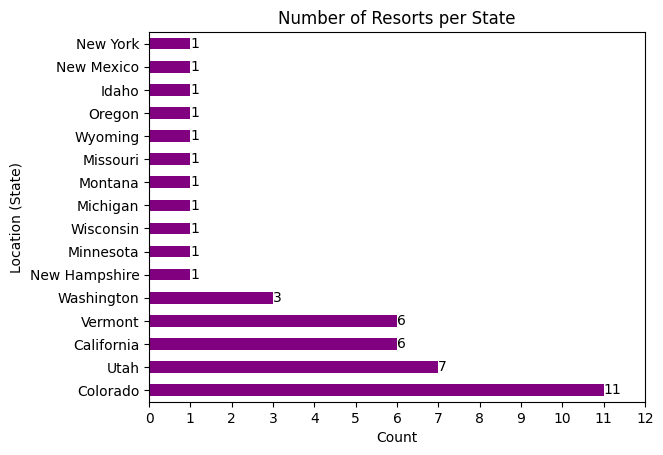

In [101]:
## preliminary charts: 
# Where are resorts located?
ByState = US_Resorts["Location (State)"].value_counts().plot(kind = "barh", color= "purple")
plt.title("Number of Resorts per State")
plt.xlabel("Count")
plt.bar_label(ByState.containers[0])
plt.xticks(np.arange(0, 13, step = 1))

statsmodels mosaic not available or failed, using stacked bar fallback: name 'mpatches' is not defined


<Figure size 1400x600 with 0 Axes>

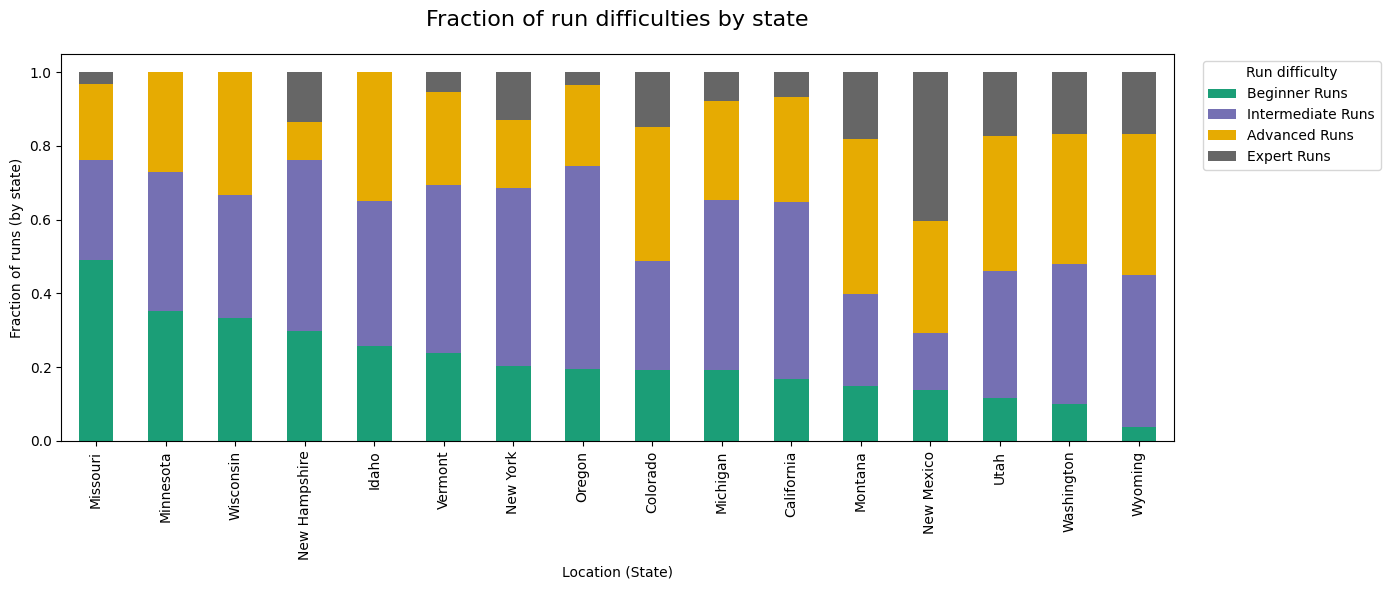

In [102]:
# How difficult are runs in these states? 
# Making a plot to show the fraction of runs of varying difficulties for each state:

# difficulty columns (ensure numeric)
difficulty_cols = ["Beginner Runs", "Intermediate Runs", "Advanced Runs", "Expert Runs"]
for c in difficulty_cols:
    US_Resorts[c] = pd.to_numeric(US_Resorts[c].astype(str).str.replace(",", "", regex=False), errors="coerce").fillna(0)

# aggregate counts by state
by_state = US_Resorts.groupby("Location (State)")[difficulty_cols].sum()

# try mosaic (statsmodels). If not installed, draw stacked bar as fallback.
try:
    # from statsmodels.graphics.mosaicplot import mosaic

    # build mapping (state, difficulty) -> count
    mosaic_data = {}
    for state in by_state.index:
        for diff in difficulty_cols:
            val = by_state.loc[state, diff]
            # mosaic requires positive values for boxes; include zeros (they'll be ignored)
            mosaic_data[(state, diff)] = float(val)

    # color palette per difficulty
    palette = sns.color_palette("Dark2", n_colors=len(difficulty_cols))
    color_map = {diff: palette[i] for i, diff in enumerate(difficulty_cols)}

    plt.figure(figsize=(14, 6))
    props = lambda key: {"color": color_map[key[1]]}
    # mosaic(mosaic_data, index=[0, 1], gap=0.01, properties=props)

    # custom legend
    patches = [mpatches.Patch(color=color_map[d], label=d) for d in difficulty_cols]
    plt.legend(handles=patches, title="Run difficulty", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.title("Mosaic plot: distribution of run difficulties aggregated by state")
    plt.tight_layout()
    plt.show()

except Exception as e:
    # fallback: stacked bar chart of fractions per state
    print("statsmodels mosaic not available or failed, using stacked bar fallback:", e)

    frac_by_state = by_state.div(by_state.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
    frac_by_state = frac_by_state.sort_values(by=difficulty_cols, ascending=False)

    ax = frac_by_state.plot(kind="bar", stacked=True, figsize=(14, 6), colormap="Dark2")
    ax.set_ylabel("Fraction of runs (by state)")
    ax.set_xlabel("Location (State)")
    ax.set_title("Fraction of run difficulties by state", fontsize=16, pad=20)
    plt.legend(title="Run difficulty", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

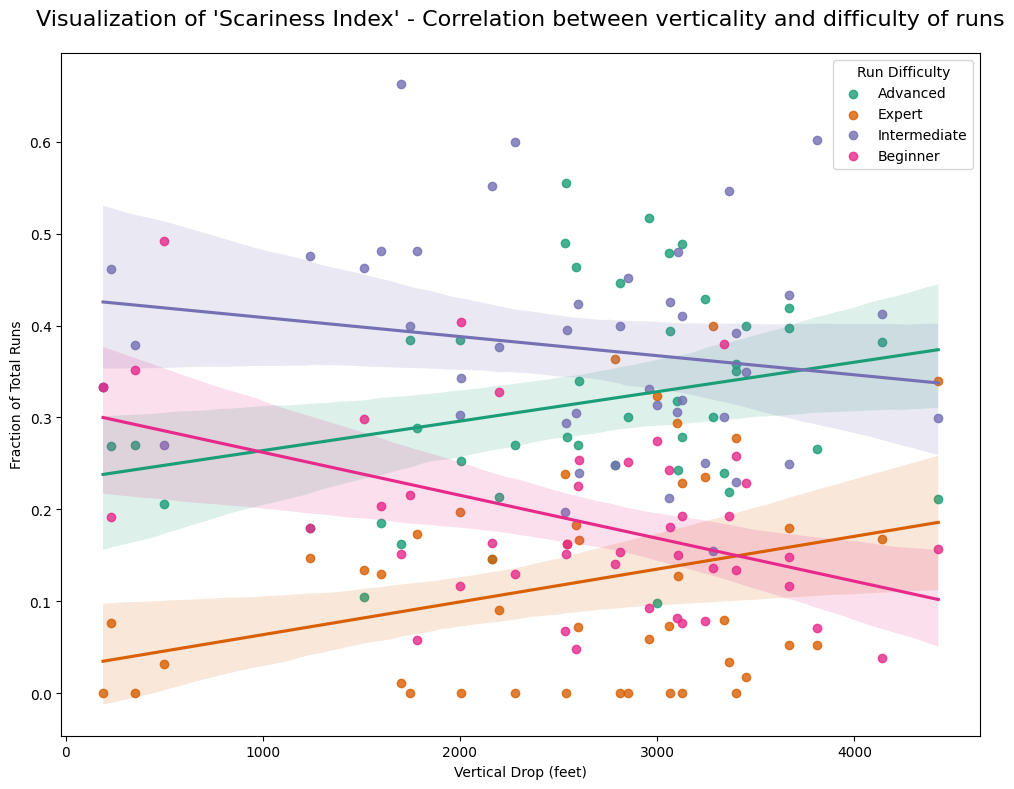

In [103]:
# Hmmm... Based on thata information, you might think, 
#   "That makes sense- of course places like Missouri and Wisconsin wouldn't have many expert runs
#   while more mountainous places like Wyoming and Montana do."
# Do we see a relationship between how moutnainous a resort is and how difficult the runs are?

 # dataframe for "difficulty"
diff = pd.DataFrame(index=US_Resorts.index)
diff["Resort"] = US_Resorts.get("Resort", US_Resorts.index)
# add vertical_ft to diff (ensure numeric)



# columns to use:
diff_cols = ["Beginner Runs", "Intermediate Runs", "Advanced Runs", "Expert Runs"]
total_col = "Total Runs"

# initialize diff with an index and identifier column
diff = pd.DataFrame(index=US_Resorts.index)
diff["Resort"] = US_Resorts.get("Resort", US_Resorts.index)
diff["vertical_ft"] = pd.to_numeric(US_Resorts.get("vertical_ft", pd.Series(index=US_Resorts.index)), errors="coerce")
# add resort location/state to diff
diff["Location (State)"] = US_Resorts.get("Location (State)", pd.Series(index=US_Resorts.index, dtype="object"))

for c in diff_cols:
    US_Resorts[c] = pd.to_numeric(US_Resorts[c].astype(str).str.replace(",", "", regex=False), errors="coerce")
    base_name = c.lower().replace(" ", "_")      # e.g. "beginner_runs"
    frac_col = f"{base_name}_frac"               # fraction of total runs

    diff[frac_col] = US_Resorts[c] / US_Resorts[total_col]

# handle infinite results and keep NaNs for missing/zero totals
diff.replace([np.inf, -np.inf], np.nan, inplace=True)


## "diff" is a dataframe containing the decimal fraction of different run difficulties
# verticality vs % difficult runs (or what I'm calling: scariness index)
import scipy

plt.figure(figsize= (10,8))
col = sns.color_palette("Dark2", 4)
sc_in = sns.regplot(x = US_Resorts["vertical_ft"], y = diff["advanced_runs_frac"], color = col[0], label = "Advanced")

sc_in2 = sns.regplot(x = US_Resorts["vertical_ft"], y = diff["expert_runs_frac"], color = col[1], label = "Expert") # expert runs

sc_in_neg1 = sns.regplot(x = US_Resorts["vertical_ft"], y = diff["intermediate_runs_frac"], color = col[2], label = "Intermediate")

sc_in_neg2 = sns.regplot(x = US_Resorts["vertical_ft"], y = diff["beginner_runs_frac"], color = col[3], label = "Beginner")


# sc_in_comb = sns.regplot(x = US_Resorts["vertical_ft"], y = diff["advanced_runs_frac"] + diff ["expert_runs_frac"])
    # combined expert and advanceed runs
plt.legend(title="Run Difficulty", loc='best')
plt.xlabel("Vertical Drop (feet)")
plt.ylabel("Fraction of Total Runs")
plt.title("Visualization of 'Scariness Index' - Correlation between verticality and difficulty of runs", 
          fontsize = 16, pad = 20)

plt.tight_layout()
plt.show()
# this plot shows how the % of run difficulty is related to the verticality (slope) of the resort
    # the most positive slope is expert, and the most negative is beginner, which makes sense!

What does this show us?
- Expert and Advanced runs have a postive correlation with vertical drop/steepness
    - a greater fraction of more difficult runs is associated with steeper slopes
- Intermediate and Beginner runs have a negative correlation with vertical drop/steepness
    - a greater fraction of easier runs is associated with less steep slopes

But it's kind of a mess. How else can we visualize this?

/tmp/ipykernel_1950/1579332969.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resort_diff_byFrac.at[idx, "difficulty_score_byFrac"] = score
/tmp/ipykernel_1950/1579332969.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Resort_diff_byFrac["ScarinessIndex"] = Resort_diff_byFrac["vertical_ft"]*Resort_diff_byFrac["difficulty_score_byFrac"]


Midline = mean Scariness Index for resorts in given state
Regression stats: slope=1635.6918739530604, intercept=-1295.244260536695, rvalue=0.49598986867099754, pvalue=0.0006174707464999122, stderr=441.86337444385043


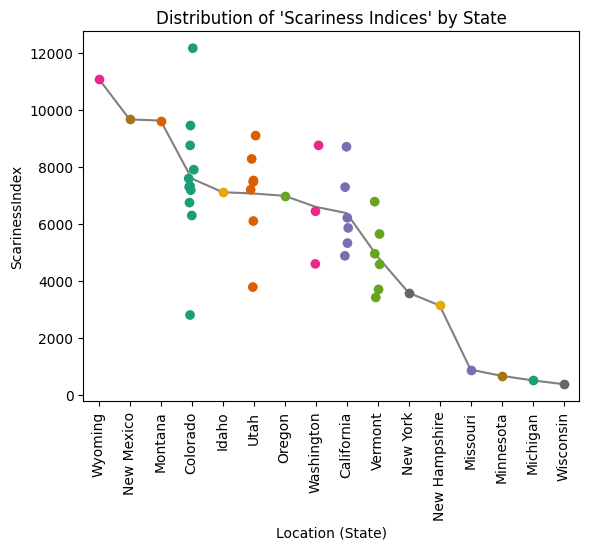

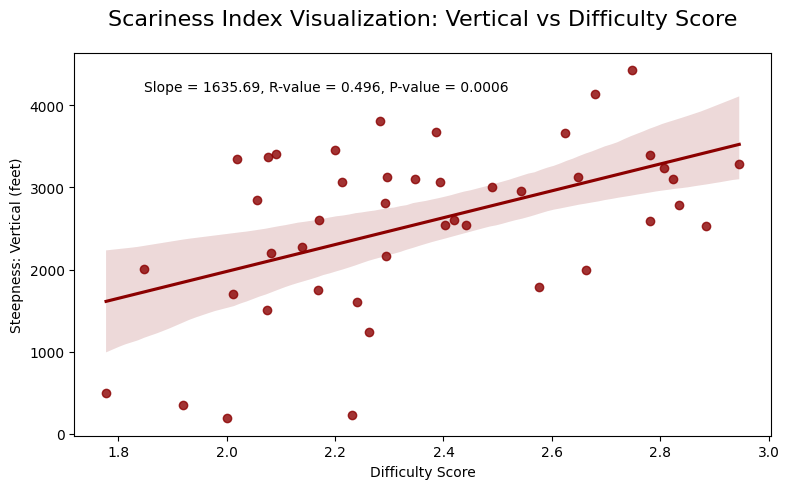

In [104]:

# Okay since there's a relationship, I would consider resorts with steep AND difficult runs "scarier" than those with little verticality and easier runs.
    # Therefore, let's assign each resort a "Scariness Index" as a function of a "difficulty score" * vertical
    # (difficulty score is a weighted sum of the % of runs of each difficulty level)
## calculating a "Scariness Index"
Resort_diff_byFrac = diff[["Resort", "Location (State)", "vertical_ft", "beginner_runs_frac", "intermediate_runs_frac", "advanced_runs_frac", "expert_runs_frac"]]
Resort_diff_byFrac.head()

cols = ["Beginner Runs", "Intermediate Runs", "Advanced Runs", "Expert Runs"]

# assign weights to difficulties
weights = {"beginner_runs_frac": 1, "intermediate_runs_frac": 2, "advanced_runs_frac": 3, "expert_runs_frac": 4}


# loop for calculating a difficulty score (weighted sum of each resort)
for idx, row in Resort_diff_byFrac.iterrows():
    score = 0.0
    for col, w in weights.items():
        v = row.get(col, 0)
        # skip when value is 0 so scores aren't 0 from multiplicaiton
        if pd.isna(v) or v == 0:
            continue
        score += float(v) * w
    Resort_diff_byFrac.at[idx, "difficulty_score_byFrac"] = score

## calculate "scariness index" value ##
    # defined as "difficulty score" * "vertical"
Resort_diff_byFrac["ScarinessIndex"] = Resort_diff_byFrac["vertical_ft"]*Resort_diff_byFrac["difficulty_score_byFrac"]
Resort_diff_byFrac.head()


# Going back to our state distributions, how do states compare based on "Scariness Index"
    # this is a way for us to simplify the interpretation of difficulty distribution and average steepness (vertical)
    # we will compare it to the visualization of Steepness (vertical) vs Difficulty Score

# scariness Index by state:

SI_states = Resort_diff_byFrac.groupby("Location (State)")["ScarinessIndex"].mean()
SI_states = SI_states.sort_values(ascending = False)
plt.plot(SI_states, color = "gray") # average line
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.title("Distribution of 'Scariness Indices' by State")
print("Midline = mean Scariness Index for resorts in given state")

# scatterplot/striplot of all scariness indices, color-coded by state
SP = sns.stripplot(data = Resort_diff_byFrac, x = "Location (State)", y = "ScarinessIndex", hue = "Location (State)", palette = "Dark2", size= 7)
SP

# visualizing scariness via regression plot:
fig2 = plt.figure(figsize= (8, 5))
sns.regplot(data = Resort_diff_byFrac, x = "difficulty_score_byFrac", y = "vertical_ft", color = "DarkRed")
plt.title("Scariness Index Visualization: Vertical vs Difficulty Score", fontsize = 16, pad = 20)
plt.xlabel("Difficulty Score")
plt.ylabel("Steepness: Vertical (feet)")
stats = scipy.stats.linregress(Resort_diff_byFrac["difficulty_score_byFrac"], Resort_diff_byFrac["vertical_ft"])
print(f"Regression stats: slope={stats.slope}, intercept={stats.intercept}, rvalue={stats.rvalue}, pvalue={stats.pvalue}, stderr={stats.stderr}")
plt.annotate("Slope = 1635.69, R-value = 0.496, P-value = 0.0006", xy=(0.1, 0.9), xycoords='axes fraction')
plt.tight_layout()
plt.show()


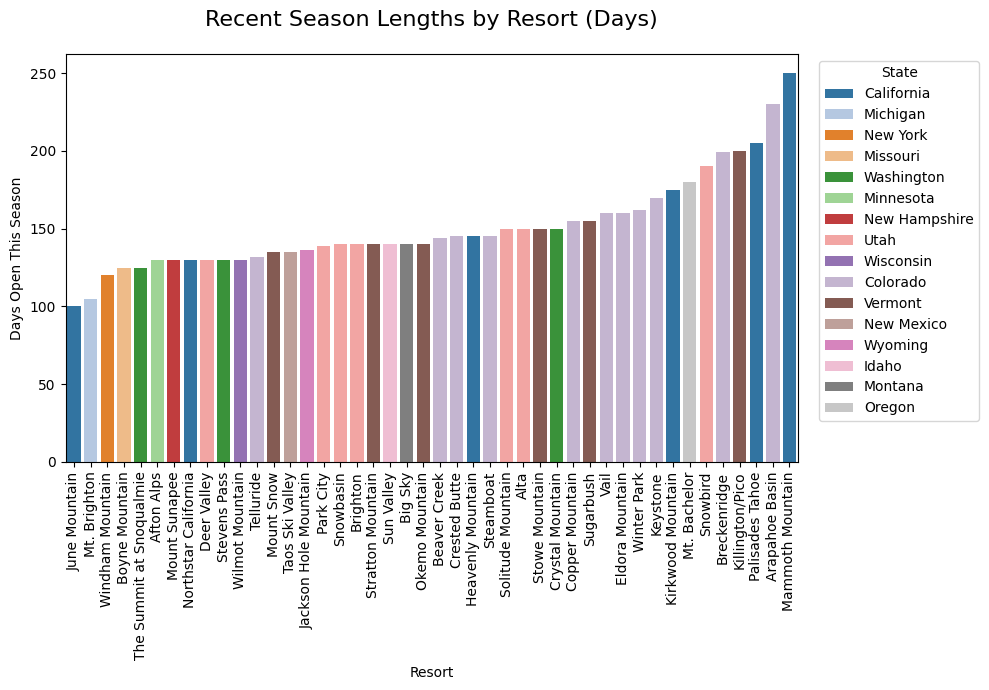

LinregressResult(slope=np.float64(nan), intercept=np.float64(nan), rvalue=np.float64(nan), pvalue=np.float64(nan), stderr=np.float64(nan), intercept_stderr=np.float64(nan))


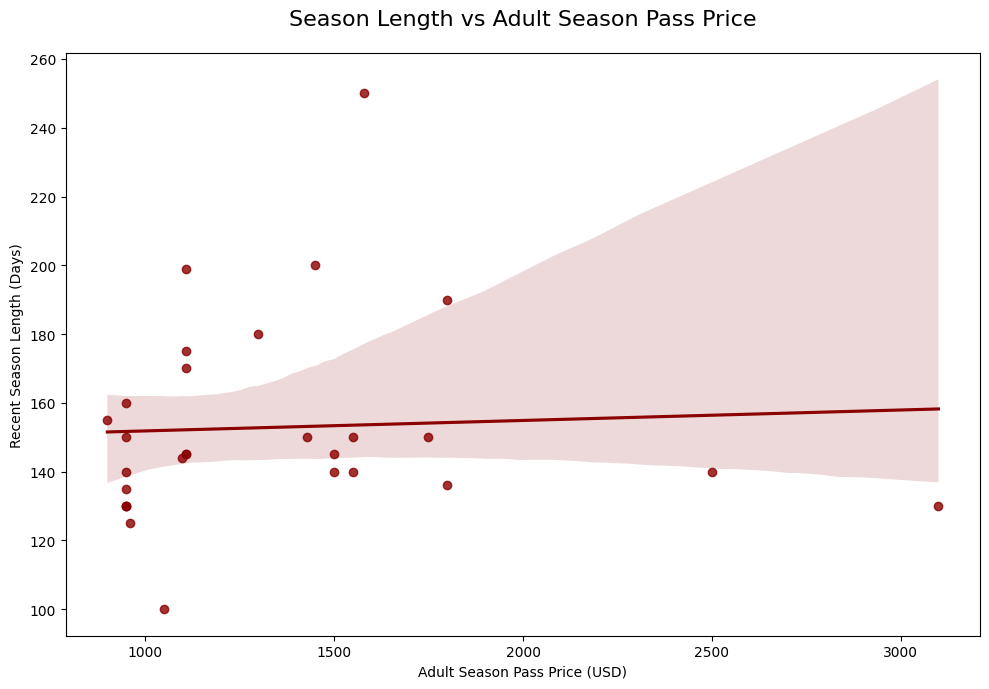

In [105]:
# What about price? Where can I afford to ski?

# Well, if a resort is expensive, it better be open for a long time!
    # distribution of days open (stripplot?)
from adjustText import adjust_text
plt.figure(figsize = (10,7))
DaysOpen = US_Resorts[["Resort", "Location (State)", "Days Open This Season"]].sort_values(by = "Days Open This Season", ascending=True)
sns.barplot(data=DaysOpen, x="Resort", y="Days Open This Season", 
            hue="Location (State)",  # This colors by state
            palette="tab20",  # More colors for multiple states (can't use "Dark2")
            dodge=False,  # Don't separate bars by hue
            legend=True)
plt.xticks(rotation = 90)
plt.legend(title = "State", loc = "best", bbox_to_anchor=(1.02, 1))
plt.title("Recent Season Lengths by Resort (Days)", fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()

    # days open vs price (scatter)

US_Prices = pd.read_csv("/workspaces/DS_project/Cleaned_Data/USResorts_WPrice.csv")

plt.figure(figsize = (10,7))
US_Prices = US_Prices.drop(index = US_Prices[US_Prices["Resort"] == "Aspen Snowmass"].index)
US_Prices["Season Pass Adult"] = US_Prices["Season Pass Adult"].dropna().astype("float64")
US_Prices["Days Open This Season"] = US_Prices["Days Open This Season"].dropna().astype("Int64")
sns.regplot(data = US_Prices, x = "Season Pass Adult", y = "Days Open This Season", color="DarkRed")
scipy.stats.linregress(US_Prices["Season Pass Adult"], US_Prices["Days Open This Season"])
print(scipy.stats.linregress(US_Prices["Season Pass Adult"], US_Prices["Days Open This Season"]))
plt.title("Season Length vs Adult Season Pass Price", fontsize = 16, pad = 20)
plt.xlabel("Adult Season Pass Price (USD)")
plt.ylabel("Recent Season Length (Days)")
# plt.annotate("Slope = 1635.69, P-value = 0.0006", xy=(0.1, 0.9), xycoords='axes fraction') --> stats aren't working :(
plt.tight_layout()
plt.show()


LinregressResult(slope=np.float64(1.6863731417233272), intercept=np.float64(53.77521801531043), rvalue=np.float64(0.3919999088419034), pvalue=np.float64(0.008497668175184518), stderr=np.float64(0.6106811167517159), intercept_stderr=np.float64(93.9645570665773))


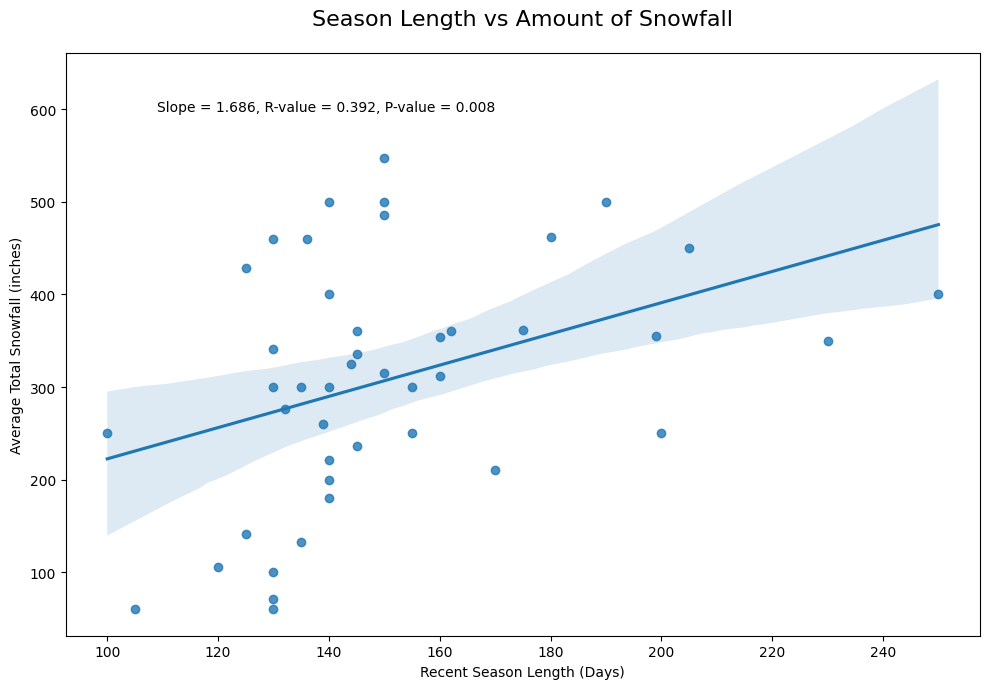

In [106]:
# Can we assume that the places that are open longer have more snowfall (I don't wanna be skiing on grass...)

plt.figure(figsize = (10,7))
sns.regplot(data = US_Resorts, x = "Days Open This Season", y = "Avg Total Snowfall (inches)")
scipy.stats.linregress(US_Resorts["Days Open This Season"], US_Resorts["Avg Total Snowfall (inches)"])
print(scipy.stats.linregress(US_Resorts["Days Open This Season"], US_Resorts["Avg Total Snowfall (inches)"]))
plt.annotate("Slope = 1.686, R-value = 0.392, P-value = 0.008", xy=(0.1, 0.9), xycoords='axes fraction')
plt.title("Season Length vs Amount of Snowfall", fontsize = 16, pad = 20)
plt.xlabel("Recent Season Length (Days)")
plt.ylabel("Average Total Snowfall (inches)")
plt.tight_layout()
plt.show()


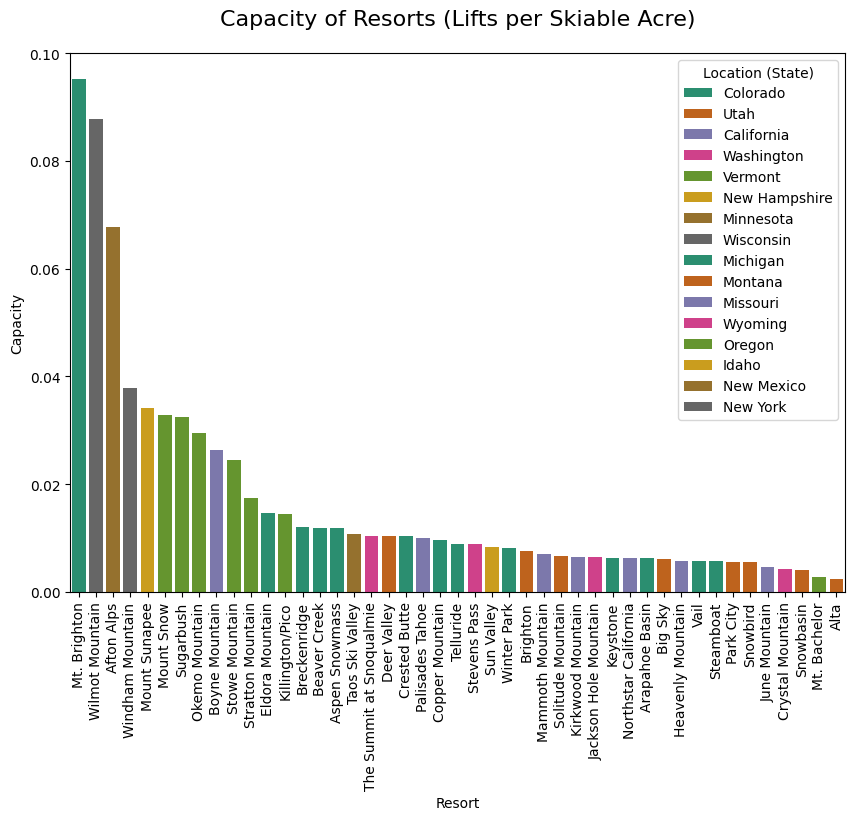

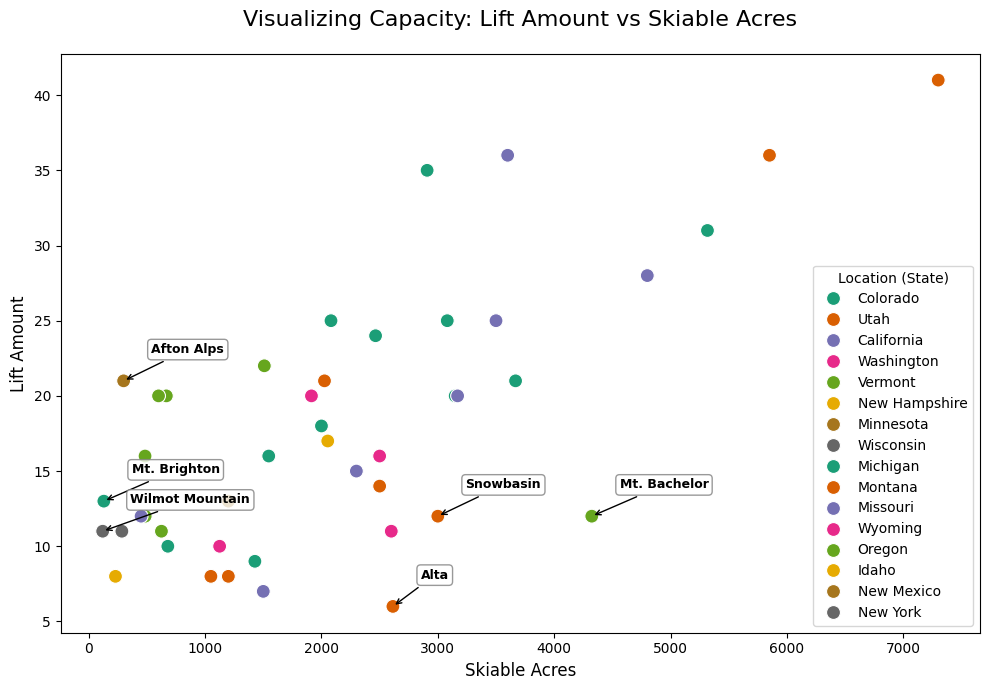

In [107]:
# What if the resort is super busy? Will there be lines for lifts?
    # here, we create a metric called "Capacity" that described the number of lifts relative to total skiable area
        # (basically a "lifts per acre" value)

# upload files:
RunDifficultyFrac = pd.read_csv("/workspaces/DS_project/ipynb_outputs/USResort_DifficultyFractions.csv")
Resorts = pd.read_csv("/workspaces/DS_project/ipynb_outputs/US_results_ext.csv")
to_remove = ["Unnamed: 0.1", "Unnamed: 0", "Skiable Terrain (Acres)", 
             "Top Elevation (ft)", "Years Open", "DifficultyScore", "trails"]
Resorts = Resorts.drop(columns = to_remove)


# replace # of runs of each difficulty with *fraction* of runs of each difficulty

RDF = RunDifficultyFrac.drop(columns = ["Unnamed: 0", "vertical_ft", "Location (State)"])

# drop counts of urn difficulties
todrop = ["Beginner Runs", "Intermediate Runs", "Advanced Runs", "Expert Runs"]
Resorts_RDF = Resorts.drop(columns = todrop)

# add in the faction columns
RDF["Resort"] = RDF["Resort"].astype(str)
Resorts_RDF["Resort"] = Resorts_RDF["Resort"].astype(str)

Resorts_RDF = Resorts_RDF.merge(RDF, on = "Resort", how = "inner")
Resorts_RDF = Resorts_RDF.drop(columns = ["Unnamed: 0.1", "Unnamed: 0", "Night Skiing"], errors = "ignore")
Resorts_RDF.head()                                          

# Defining **Capacity**
# create a column of "capacity", which is number of lifts per skiable acre (Total Lifts/skiable_acres)
Resorts_RDF["Capacity"] = np.log(1 + (Resorts_RDF["Lift Amount"] / Resorts_RDF["skiable_acres"])) # "Capacity" is a proxy for how long lines might be or how crowded the slopes may feel
    # more lifts per skiable acres = higher "capacity"; fewer lifts but many skiable acres = lower "capacity"
Resorts_RDF.head()

## please note: Capacity is a made-up metric, and does not reflect differences in the types of skiing available 
#   (some skiable terrain may be for backcountry or cross-country skiing, which would not require lifts, for example)


# plotting capacity for each resort
plt.figure(figsize = (10,7))
sns.barplot(data = Resorts_RDF, x = "Resort", y = "Capacity", hue = "Location (State)", palette = "Dark2", order=Resorts_RDF.sort_values("Capacity", ascending = False)["Resort"])
plt.xticks(rotation = 90)
plt.title("Capacity of Resorts (Lifts per Skiable Acre)", fontsize = 16, pad = 20)


plt.figure(figsize=(10, 7))
sns.scatterplot(data=US_Resorts, 
                x="skiable_acres", 
                y="Lift Amount", 
                hue="Location (State)", 
                palette="Dark2", 
                s=100)

# List of resorts to label
resorts_to_label = ["Mt. Brighton", "Wilmot Mountain", "Afton Alps", 
                    "Snowbasin", "Mt. Bachelor", "Alta"]

# Annotate with arrows
for resort_name in resorts_to_label:
    resort_data = US_Resorts[US_Resorts["Resort"] == resort_name]
    if not resort_data.empty:
        x_val = resort_data["skiable_acres"].values[0]
        y_val = resort_data["Lift Amount"].values[0]
        
        plt.annotate(resort_name, # annotating the top 3 resorts and bottom 3 resorts based on Capacity Score
                    xy=(x_val, y_val),  # Point location
                    xytext=(20, 20),  # Label offset (adjust as needed)
                    textcoords='offset points',
                    fontsize=9,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='black', lw=1))

plt.title("Visualizing Capacity: Lift Amount vs Skiable Acres", fontsize=16, pad=20)
plt.xlabel("Skiable Acres", fontsize=12)
plt.ylabel("Lift Amount", fontsize=12)
plt.tight_layout()
plt.show()


# plotting capacity vs scariness index (because why not?) # idk if i'll actually do this

In [108]:
## making resort prescriptions for our intersted skiiers:

# Skiier 1)
    # - would probably want a resort in one of the following states:
        # 
    

## Step 3) Predictive Analysis and Modeling ##
(with some more descriptive visualizations along the way)

In [109]:
# importing necessary tools:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

### Q1: Which resorts are similar? Which are different?

building a dendrogram to group resorts based on features 

Numeric columns used for clustering: ['Days Open This Season', 'Avg Total Snowfall (inches)', 'Beginner Runs', 'Intermediate Runs', 'Advanced Runs', 'Expert Runs', 'Lift Amount', 'Total Runs', 'skiable_acres', 'base_elevation_ft', 'top_elevation_ft', 'vertical_ft', 'historical_average_snowfall_inches', 'historical_average_snowfall_days', 'Longest Run', 'Snow Making', 'ScarinessIndex']
         Resort Ski Pass Location (State)  Days Open This Season  \
0      Keystone     Epic         Colorado                    170   
1  Breckenridge     Epic         Colorado                    199   
2          Vail     Epic         Colorado                    160   
3     Park City     Epic             Utah                    139   
4  Beaver Creek     Epic         Colorado                    144   

   Avg Total Snowfall (inches)  Beginner Runs  Intermediate Runs  \
0                          210             26                 43   
1                          355             25                 43   

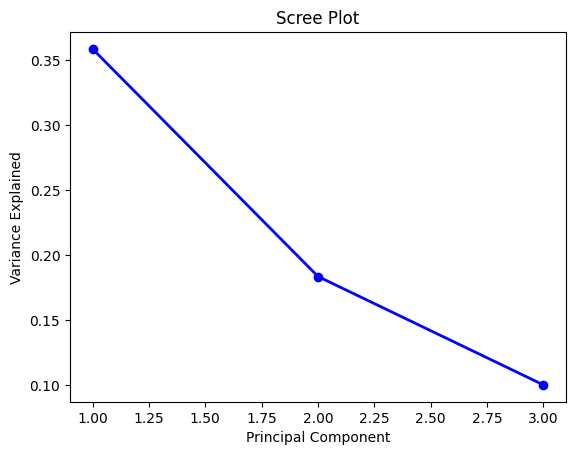

In [ ]:
## create a model for clustering of resorts ##
# first need to create a matrix or whatever

numeric_cols = Resorts.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns used for clustering:", numeric_cols)
print(Resorts.head())  # show DataFrame head

# build feature matrix from numeric columns
X = Resorts[numeric_cols].copy()

# choose how to handle missing values: fill or drop; here fill with 0
X = X.fillna(0)

# scaling and normalizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_normalized = normalize(X_scaled)
X_normalized = pd.DataFrame(X_normalized)

## using PCA to reduce the dimentionality of the data
pca = PCA(n_components=3)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal, index = Resorts["Resort"].astype(str))
X_principal.columns = ["P1", "P2", "P3"]

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# when I created a Scree Plot for different number of principal components, the "Elbow" was at 3, 
# so I "dropped" the other PCs and used 3 components for the dendrogram

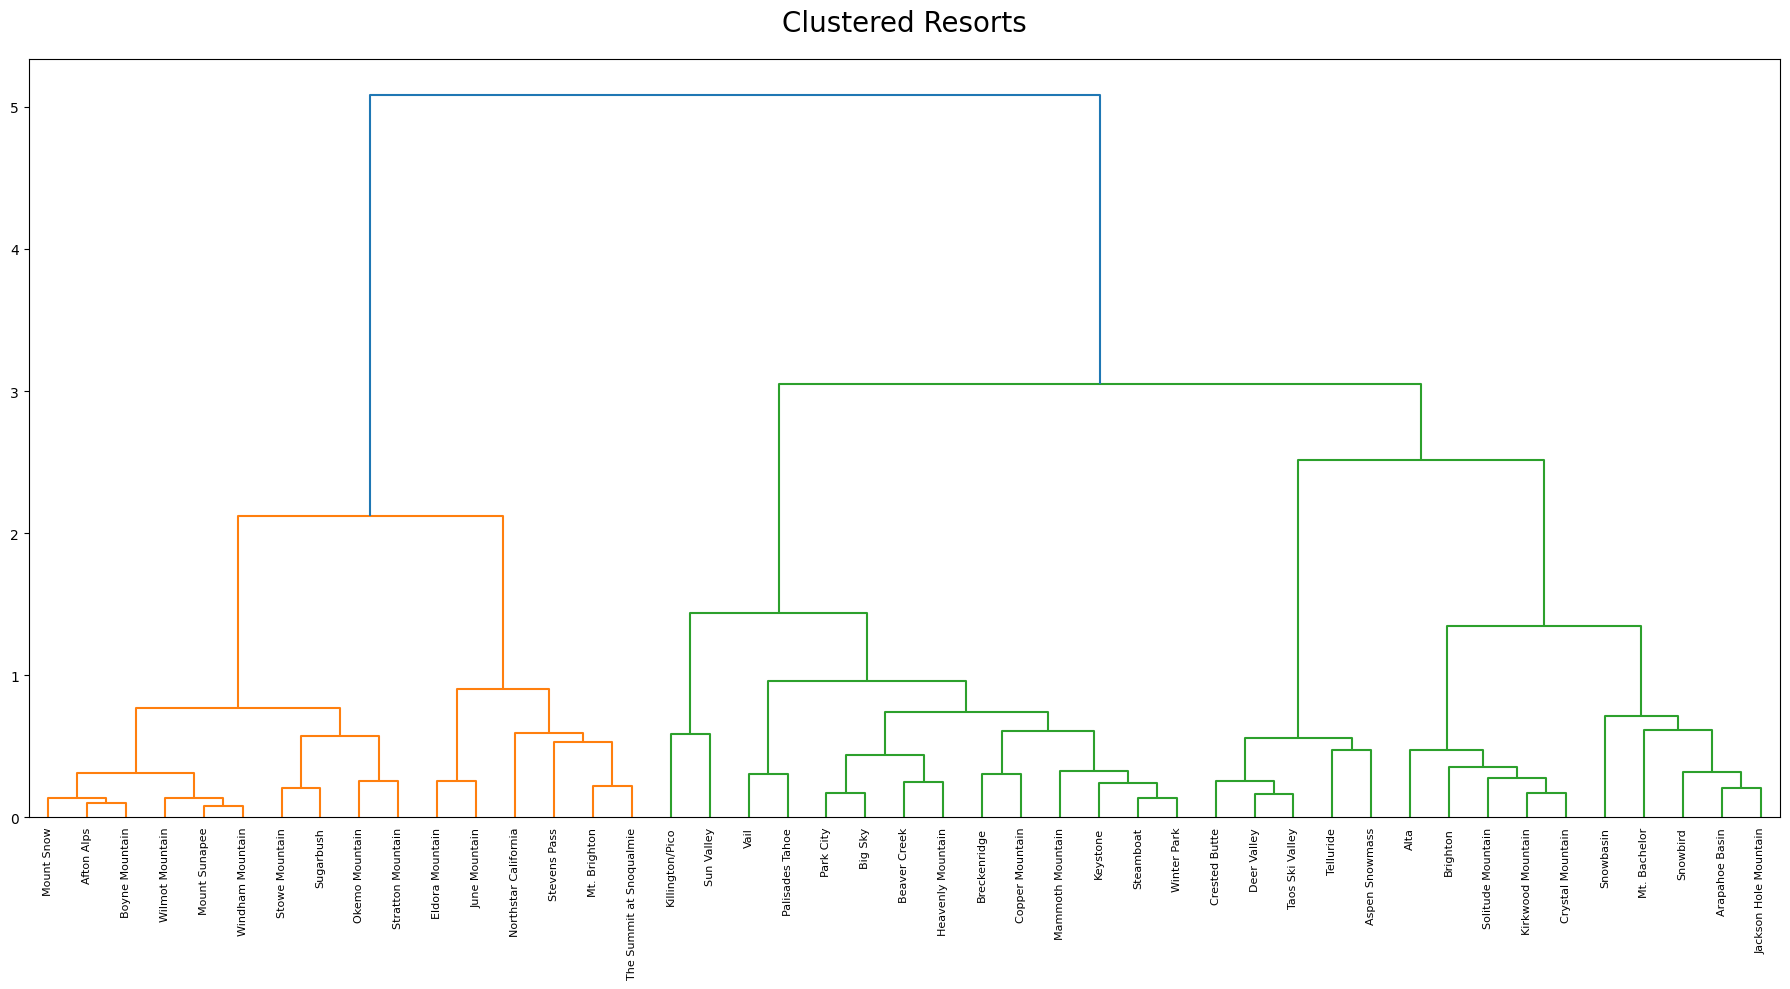

In [111]:
## creating dendrogram to visualize clusters
## Dendrograms!
plt.figure(figsize= (18,10))
plt.title("Clustered Resorts", fontsize = 20, pad = 20)
Dendrogram = shc.linkage(X_principal.values, method = "ward")
shc.dendrogram(Dendrogram, labels=X_principal.index.tolist(), leaf_rotation=90, leaf_font_size=8)
plt.tight_layout()
plt.show()

With the dendrogram, we can see which resorts are most similar. This can be used to create a "if you like *this* resort, try *this* one" guide.


### Q2: Is there a differnce between Epic and Ikon resorts? 
We will answer this by building a model and seeing how well it can predict the pass type of a resort given the available features

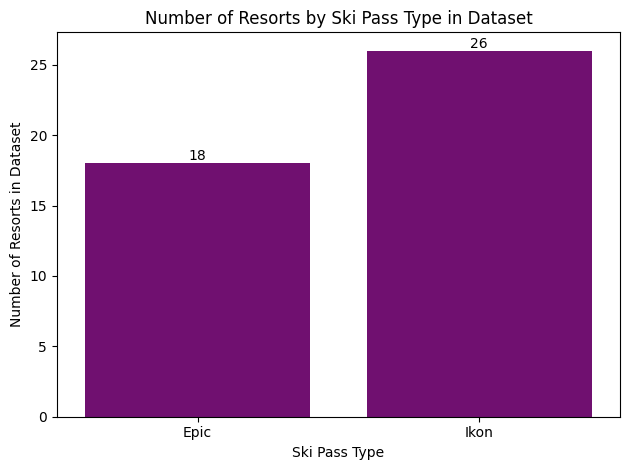

In [112]:
## bring in Pass Type data:
Resorts = pd.read_csv("/workspaces/DS_project/ipynb_outputs/US_results_ext.csv")
RunDifficultyFrac = pd.read_csv("/workspaces/DS_project/ipynb_outputs/USResort_DifficultyFractions.csv")\

# quick cleaning:
    ## clean up "Resorts" to only have the columns I want
to_remove = ["Unnamed: 0.1", "Unnamed: 0", "Skiable Terrain (Acres)", 
             "Top Elevation (ft)", "Years Open", "DifficultyScore", "trails"]
Resorts = Resorts.drop(columns = to_remove)
    # Resorts.to_clipboard("Resorts_limitedColumns")

 
#  3a) How many resorts do we have for each pass type?
    # **important note: this is NOT encompass ALL resorts within these pass types,
    # this is based on what we ended up with after combining datasets in the beginning!

sns.barplot(x=["Epic", "Ikon"], y=[len(Resorts_all[Resorts_all["Ski Pass"] == "Epic"]), 
                                   len(Resorts_all[Resorts_all["Ski Pass"] == "Ikon"])], color="purple")
plt.bar_label(plt.gca().containers[0])
plt.xlabel("Ski Pass Type")
plt.ylabel("Number of Resorts in Dataset")
plt.title("Number of Resorts by Ski Pass Type in Dataset")
plt.tight_layout()
plt.show()


## Now let's see how some variables differ by pass type:



In [113]:
# prepping data:
# step 1) take the resort data and separate it into "ikon" and "epic"; then plot different features:

Epic = Resorts_RDF[Resorts_RDF["Ski Pass"] == "Epic"]
Epic.head()

Ikon = Resorts_RDF[Resorts_RDF["Ski Pass"] == "Ikon"]
pd.set_option('display.max_columns', None)
Ikon.head()


,Resort,Ski Pass,Location (State),Days Open This Season,Avg Total Snowfall (inches),Lift Amount,Total Runs,skiable_acres,base_elevation_ft,top_elevation_ft,vertical_ft,historical_average_snowfall_inches,historical_average_snowfall_days,Limited or unlimited,Longest Run,Snow Making,ScarinessIndex,beginner_runs_frac,intermediate_runs_frac,advanced_runs_frac,expert_runs_frac,Capacity
18,Alta,Ikon,Utah,150,547,6,119,2614.0,8530,11068,2538,399.0,66.0,limited,1.3,140,6099.73,0.151261,0.294118,0.554622,0.000000,0.002293
19,Arapahoe Basin,Ikon,Colorado,230,350,9,147,1428.0,10520,13050,2530,276.0,87.0,limited,1.5,125,7297.41,0.068027,0.197279,0.489796,0.238095,0.006283
20,Aspen Snowmass,Ikon,Colorado,150,300,8,76,673.0,8040,12510,4470,309.0,66.0,limited,5.3,658,16468.42,0.026316,0.631579,0.342105,0.342105,0.011817
21,Big Sky,Ikon,Montana,140,400,36,317,5850.0,7500,11166,3666,267.0,69.0,limited,6.0,400,9621.80,0.148265,0.249211,0.419558,0.179811,0.006135
22,Boyne Mountain,Ikon,Missouri,125,141,12,63,450.0,620,1120,500,113.0,44.0,limited,1.0,380,888.89,0.492063,0.269841,0.206349,0.031746,0.026317


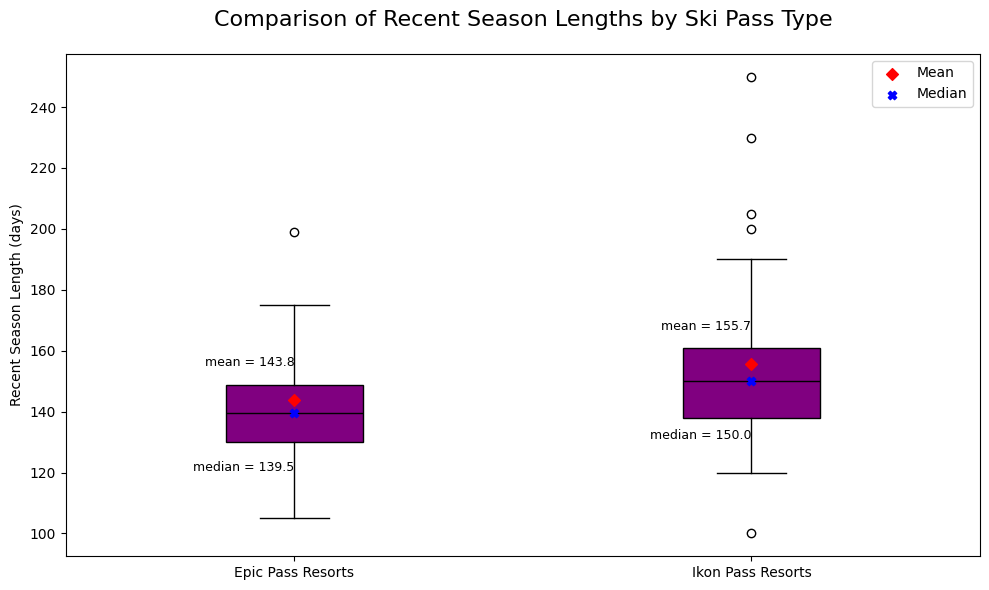

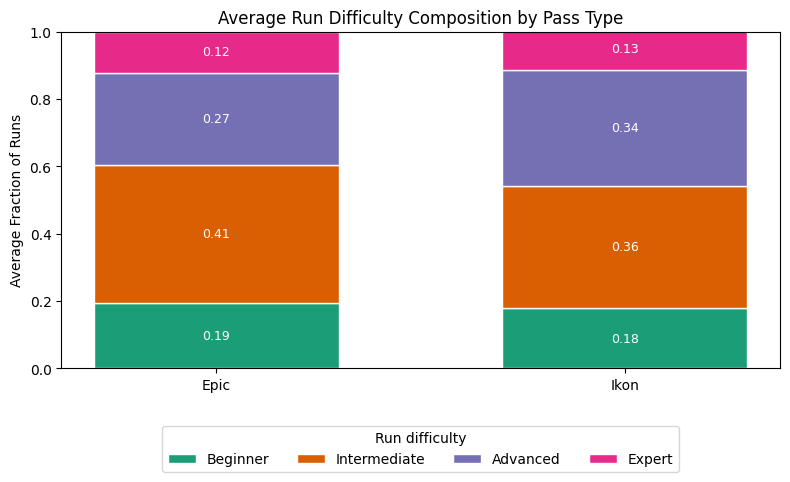

/tmp/ipykernel_1950/3909439658.py:122: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  fig.legend(handles, labels, title="Run difficulty", bbox_to_anchor=(0.5, 0.02), loc="lower center", ncol=len(frac_cols), labels = col_names)


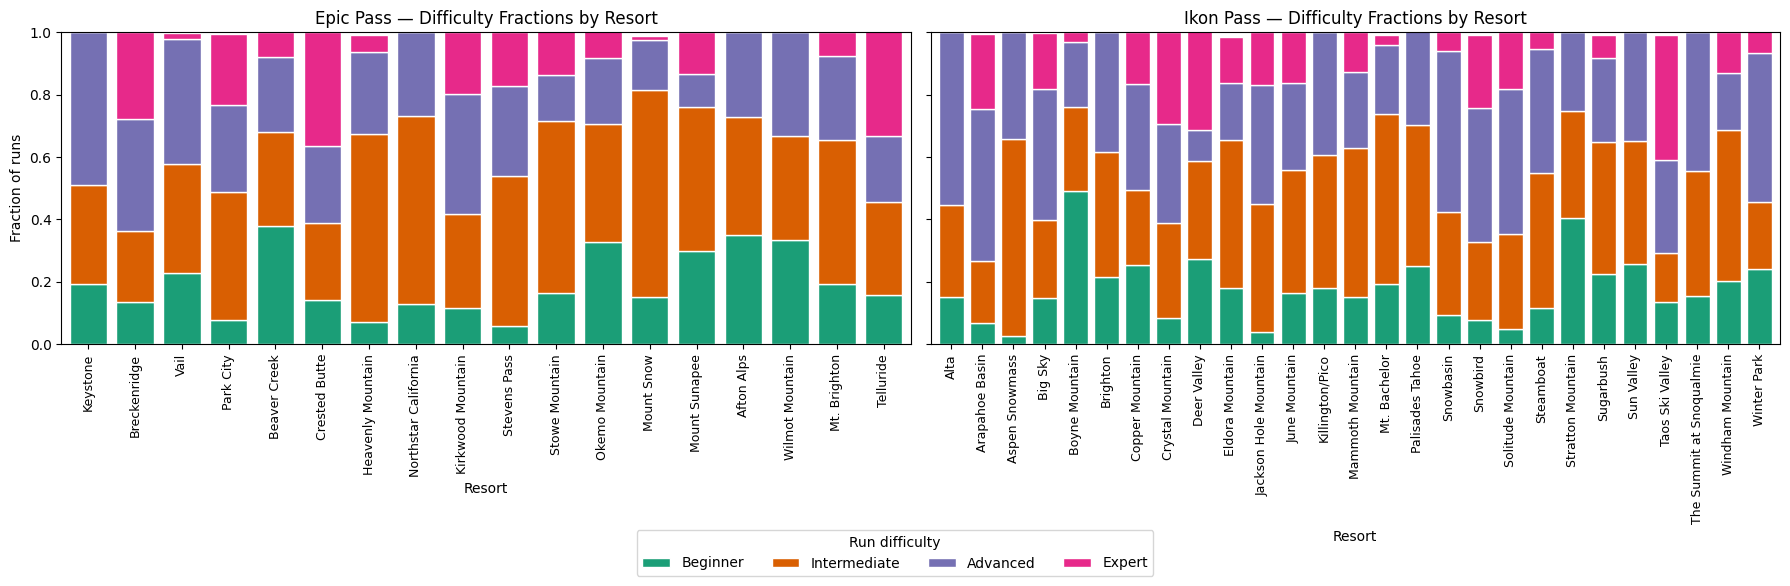

In [114]:
## questions you might ask about differences between the pass types:

# 1) Are season lengths different?
    # box plot of season lengths between pass types:

plt.figure(figsize = (10,6))

EpicSeason = Epic["Days Open This Season"].dropna()
IkonSeason = Ikon["Days Open This Season"].dropna()
x = [EpicSeason, IkonSeason]
positions = [1,2]
plt.boxplot(x, positions= positions, widths = 0.3,patch_artist=True, boxprops=dict(facecolor = "purple"),  medianprops=dict(color="black"))
plt.xticks(positions, ["Epic Pass Resorts", "Ikon Pass Resorts"])
plt.ylabel("Recent Season Length (days)")

# generate stats for mean and median
means = [EpicSeason.mean(), IkonSeason.mean()]  # keep short names
medians = [EpicSeason.median(), IkonSeason.median()]

# plot markers for mean and median
plt.scatter(positions, means, marker='D', color='red', zorder=5, label='Mean')
plt.scatter(positions, medians, marker='X', color='blue', zorder=5, label='Median')

# annotate values above points
for pos, val in zip(positions, means):
    plt.text(pos, val + (0.04 * max(EpicSeason.max(), IkonSeason.max())), f"mean = {val:.1f}",
             ha='right', va='bottom', color='black', fontsize=9)
for pos, val in zip(positions, medians):
    plt.text(pos, val - (0.08 * max(EpicSeason.max(), IkonSeason.max())), f"median = {val:.1f}",
             ha='right', va='bottom', color='black', fontsize=9)
    
plt.title("Comparison of Recent Season Lengths by Ski Pass Type", fontsize = 16, pad = 20)
plt.legend()
plt.tight_layout()
plt.show()


# 2) Is there a difference in the fraction of difficult runs?
## plotting stacked barplot for Epic vs Ikon difficulty fractions:

# 2a) grouped:
# single stacked bar showing average difficulty-fraction composition per pass type (Epic vs Ikon)

frac_cols = ["beginner_runs_frac", "intermediate_runs_frac", "advanced_runs_frac", "expert_runs_frac"]
col_names = ["Beginner", "Intermediate", "Advanced", "Expert"]
colors = sns.color_palette("Dark2", n_colors=len(frac_cols))

# ensure fraction columns are numeric
df = Resorts_RDF.copy()
for c in frac_cols:
    df[c] = pd.to_numeric(df.get(c, 0), errors="coerce").fillna(0)

# compute mean fraction per pass type (Epic, Ikon)
avg_by_pass = df.groupby("Ski Pass")[frac_cols].mean().reindex(["Epic", "Ikon"]).fillna(0)

# plot single stacked bar (one bar per pass type)
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(avg_by_pass))  # positions for Epic and Ikon
width = 0.6
bottom = np.zeros(len(avg_by_pass))

for col, color in zip(frac_cols, colors):
    vals = avg_by_pass[col].values
    ax.bar(x, vals, bottom=bottom, color=color, width=width, label=col, edgecolor="white")
    # annotate segment values if large enough
    for xi, btm, v in zip(x, bottom, vals):
        if v > 0.03:
            ax.text(xi, btm + v/2, f"{v:.2f}", ha="center", va="center", color="white", fontsize=9)
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(avg_by_pass.index.tolist())
ax.set_ylim(0,1)
ax.set_ylabel("Average Fraction of Runs")
ax.set_title("Average Run Difficulty Composition by Pass Type")
ax.legend(title="Run difficulty", bbox_to_anchor=(0.5, -0.15), loc="upper center", ncol=len(col_names), labels = col_names)
plt.tight_layout()
plt.show()

# 2b) separated by resort:

# stacked bar charts of difficulty fractions per resort for Epic and Ikon passes

frac_cols = ["beginner_runs_frac", "intermediate_runs_frac", "advanced_runs_frac", "expert_runs_frac"]
col_names = ["Beginner", "Intermediate", "Advanced", "Expert"]
colors = sns.color_palette("Dark2", n_colors=len(frac_cols))

# ensure Resorts_RDF exists and fraction columns are numeric
df = Resorts_RDF.copy()
for c in frac_cols:
    df[c] = pd.to_numeric(df.get(c, 0), errors="coerce").fillna(0)

epic_df = df[df["Ski Pass"] == "Epic"].reset_index(drop=True)
ikon_df = df[df["Ski Pass"] == "Ikon"].reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

def plot_stacked(ax, data, title):
    n = len(data)
    if n == 0:
        ax.text(0.5, 0.5, "No resorts", ha="center", va="center")
        return
    x = np.arange(n)
    bottom = np.zeros(n)
    for col, color in zip(frac_cols, colors):
        vals = data[col].values
        ax.bar(x, vals, bottom=bottom, color=color, edgecolor="white", width=0.8, label=col)
        bottom += vals
    ax.set_xticks(x)
    ax.set_xticklabels(data["Resort"].astype(str), rotation=90, fontsize=9)
    ax.set_title(title)
    ax.set_xlabel("Resort")
    ax.set_ylim(0, 1)
    ax.margins(x=0.01)

plot_stacked(axes[0], epic_df, "Epic Pass — Difficulty Fractions by Resort")
plot_stacked(axes[1], ikon_df, "Ikon Pass — Difficulty Fractions by Resort")

# common decorations
axes[0].set_ylabel("Fraction of runs")
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, title="Run difficulty", bbox_to_anchor=(0.5, 0.02), loc="lower center", ncol=len(frac_cols), labels = col_names)
plt.tight_layout(rect=[0, 0.06, 1, 1])
plt.show()




and a thousand other quesitons... (these are just a couple that would be interesting visuals)

Alright, let's get to the model!

Here are the variables we may consider in the model:
# variables for consideration:
    # Season:
        # Days Open This Season
        # historical_average_snowfall_days
    # Runs/Difficulty:
        # Beginner Runs (use frac)
        # Intermediate Runs (use frac)
        # Advanced Runs (use frac)
        # Expert Runs (use frac)
    # Capacity:
        # Lift Amount
        # Total Runs
        # skiable_acres
        # Capacity
    # Conditions:
        # base_elevation_ft
        # top_elevation_ft
        # vertical_ft
        # historical_average_snowfall_inches
        # Longeset Run
        # Snow Making



In [115]:
# checking for multicollinearity:
    # fist, remove variables we don't plan on using in the model anyway:
toremove = ["Limited or unlimited", "ScarinessIndex"]
Resorts_RDF = Resorts_RDF.drop(columns = toremove)

# creating a matrix
numeric_cols = Resorts_RDF.select_dtypes(include=[np.number]).columns.tolist()
print(Resorts_RDF.head())  # show DataFrame head

# build feature matrix from numeric columns
X = Resorts_RDF[numeric_cols].copy()

# choose how to handle missing values: fill or drop; here fill with 0
X = X.fillna(0)

X.corr()

         Resort Ski Pass Location (State)  Days Open This Season  \
0      Keystone     Epic         Colorado                    170   
1  Breckenridge     Epic         Colorado                    199   
2          Vail     Epic         Colorado                    160   
3     Park City     Epic             Utah                    139   
4  Beaver Creek     Epic         Colorado                    144   

   Avg Total Snowfall (inches)  Lift Amount  Total Runs  skiable_acres  \
0                          210           20         135         3149.0   
1                          355           35         187         2908.0   
2                          354           31         275         5317.0   
3                          260           41         341         7300.0   
4                          325           25         150         2082.0   

   base_elevation_ft  top_elevation_ft  vertical_ft  \
0               9280             12408         3128   
1               9600             129

,Days Open This Season,Avg Total Snowfall (inches),Lift Amount,Total Runs,skiable_acres,base_elevation_ft,top_elevation_ft,vertical_ft,historical_average_snowfall_inches,historical_average_snowfall_days,Longest Run,Snow Making,beginner_runs_frac,intermediate_runs_frac,advanced_runs_frac,expert_runs_frac,Capacity
Days Open This Season,1.000000,0.392023,0.263634,0.415538,0.276283,0.372587,0.385758,0.297509,0.303876,0.267750,0.277000,-0.055138,-0.203553,-0.130700,0.274203,0.045691,-0.345950
Avg Total Snowfall (inches),0.392023,1.000000,0.049253,0.306220,0.451554,0.555466,0.599200,0.533960,0.779027,0.554817,0.267706,0.003090,-0.535526,-0.122965,0.465909,0.150874,-0.719228
Lift Amount,0.263634,0.049253,1.000000,0.802347,0.706264,0.174124,0.237492,0.353712,0.020082,0.020281,0.384544,-0.054263,0.032564,-0.062346,0.023533,-0.059357,-0.160520
Total Runs,0.415538,0.306220,0.802347,1.000000,0.815808,0.397601,0.476493,0.560764,0.209212,0.295361,0.542795,0.013114,-0.150785,-0.208446,0.232069,0.082364,-0.450102
skiable_acres,0.276283,0.451554,0.706264,0.815808,1.000000,0.471422,0.544764,0.589095,0.430359,0.379783,0.467057,0.118632,-0.328640,-0.068145,0.313399,-0.000439,-0.543120
base_elevation_ft,0.372587,0.555466,0.174124,0.397601,0.471422,1.000000,0.975967,0.575679,0.525837,0.592031,0.336767,0.114688,-0.442613,-0.389182,0.425576,0.424834,-0.662775
top_elevation_ft,0.385758,0.599200,0.237492,0.476493,0.544764,0.975967,1.000000,0.740031,0.542255,0.615486,0.478449,0.133654,-0.496382,-0.341165,0.426474,0.447097,-0.741516
vertical_ft,0.297509,0.533960,0.353712,0.560764,0.589095,0.575679,0.740031,1.000000,0.411734,0.482214,0.755859,0.147527,-0.496469,-0.078968,0.286744,0.366413,-0.736764
historical_average_snowfall_inches,0.303876,0.779027,0.020082,0.209212,0.430359,0.525837,0.542255,0.411734,1.000000,0.707341,0.143278,-0.021086,-0.606759,-0.017569,0.451335,0.153550,-0.463588
historical_average_snowfall_days,0.267750,0.554817,0.020281,0.295361,0.379783,0.592031,0.615486,0.482214,0.707341,1.000000,0.268705,0.129229,-0.480573,-0.245513,0.531564,0.203412,-0.522265


colinear variables based on the matrix:
- avg total snowfall + capacity?
- avg total snowfall + historical average snowfall (makes sense)
    - [**get rid of avg total snowfall**]
- total runs + lift amount
- skiable acres + lift amount?
- skiable acres + total runs
    - [**get rid of "total runs"**]
- top elevation + base elevation (makes sense; **remove "top"** bc correlated w/ veritcal)
- vertical + longest run?

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                   31
Model:                            GLM   Df Residuals:                       16
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.477
Date:                Sat, 29 Nov 2025   Deviance:                       24.955
Time:                        00:07:51   Pearson chi2:                     24.3
No. Iterations:                     8   Pseudo R-squ. (CS):             0.4113
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

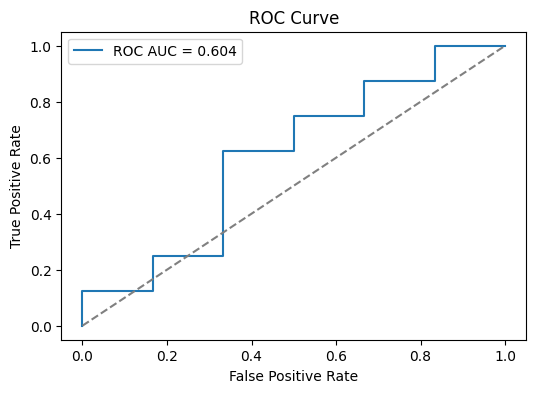

In [116]:
# removing colinear variables:
Resorts_RDF = Resorts_RDF.copy()
colinear = ["Avg Total Snowfall (inches)", "Total Runs", "top_elevation_ft"]
Resorts_RDF = Resorts_RDF.drop(columns= colinear)

# build model:
Resorts_RDF['target'] = (Resorts_RDF['Ski Pass'] == 'Ikon').astype(int) # binary target variable: 1 if Ikon, 0 if Epic

# Select predictor variables (after looking at matrix and removing highly correlated ones)
    # this step is a little redundant given that I removed colinear variables,
    #  but I think it cleans up the dataframe a bit
predictors = ['Days Open This Season',
       'Lift Amount', 'skiable_acres', 'base_elevation_ft', 'vertical_ft',
       'historical_average_snowfall_inches',
       'historical_average_snowfall_days', 'Longest Run', 'Snow Making',
       'beginner_runs_frac', 'intermediate_runs_frac', 'advanced_runs_frac',
       'expert_runs_frac', 'Capacity']

# Prepare X (features) and y (target)
X = Resorts_RDF[predictors].dropna()
y = Resorts_RDF.loc[X.index, 'target']

# Standardize predictors? (helps with convergence and interpretation... according to the internet)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Add constant term (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# Specify and fit the logistic regression model
# family=sm.families.Binomial() specifies binomial distribution
# link=sm.families.links.Logit() specifies logit link function (this is default)
logit_model = sm.GLM(y_train, X_train_const, 
                     family=sm.families.Binomial(link=sm.families.links.Logit()))

# Fit the model
result = logit_model.fit()

# Display detailed results
print(result.summary())

# prediciton?
# predicted probabilities for the positive class (Ikon)
y_pred_prob = result.predict(X_test_const)

# convert to hard classes (threshold = 0.5)
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)

# quick evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# optional: ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_pred_prob):.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Based on the results, it does not look like a model can predict whether a resort is an Ikon Pass resort or an Epic Pass resort. In other words, the difference between resorts (based on the features we have data on) is minimal.